In [35]:
import pandas as pd
import numpy as np
from finance_byu.summarize import summary
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
# Load daily and monthly crsp data

daily = pd.read_feather("crsp_daily.ftr")

monthly = pd.read_feather("crsp_monthly.ftr")

daily.head()

,permno,caldt,shrcd,excd,siccd,prc,ret,vol,shr
6411,10001,2010-01-04,11,2,4925,10.25,-0.004854,18500.0,4361.0
6412,10001,2010-01-05,11,2,4925,10.19,-0.005854,23200.0,4361.0
6413,10001,2010-01-06,11,2,4925,10.31,0.011776,18700.0,4361.0
6414,10001,2010-01-07,11,2,4925,9.96,-0.033948,29200.0,4361.0
6415,10001,2010-01-08,11,2,4925,10.34,0.038153,25100.0,4361.0


In [37]:
# Clean daily data

daily['prc'] = abs(daily['prc'])

daily.sort_values(by=['permno', 'caldt'], inplace=True)

daily = daily[['permno', 'caldt', 'prc', 'ret']]

daily['mdt'] = daily['caldt'].dt.to_period('M').astype(str)

daily.head()

,permno,caldt,prc,ret,mdt
6411,10001,2010-01-04,10.25,-0.004854,2010-01
6412,10001,2010-01-05,10.19,-0.005854,2010-01
6413,10001,2010-01-06,10.31,0.011776,2010-01
6414,10001,2010-01-07,9.96,-0.033948,2010-01
6415,10001,2010-01-08,10.34,0.038153,2010-01


In [38]:
# Create up, down, and total columns

daily['up'] = np.where(daily['ret'] > 0, 1, 0)

daily['down'] = np.where(daily['ret'] < 0, 1, 0)

daily['total'] = 1

daily.head()

MemoryError: Unable to allocate 102. MiB for an array with shape (26708294,) and data type int32

In [ ]:
# Aggregate daily data on the month level. Sum up, down, and total days in each month

daily = daily.groupby(['permno','mdt'])[['caldt','prc','up','down', 'total']].agg({'caldt': 'last','prc': 'last','up':'sum','down':'sum', 'total':'sum'})

daily.reset_index("mdt",inplace=True)
daily.reset_index("permno",inplace=True)

daily['%neg-%pos'] = (daily['down']-daily['up']) / daily['total']

daily

,permno,mdt,caldt,prc,up,down,total,%neg-%pos
0,10001,2010-01,2010-01-29,10.06000,8,11,19,0.157895
1,10001,2010-02,2010-02-26,10.00840,8,10,19,0.105263
2,10001,2010-03,2010-03-31,10.17000,12,9,23,-0.130435
3,10001,2010-04,2010-04-30,11.39000,16,5,21,-0.523810
4,10001,2010-05,2010-05-28,11.40000,10,9,20,-0.050000
...,...,...,...,...,...,...,...,...
1281434,93436,2023-08,2023-08-31,258.07999,9,14,23,0.217391
1281435,93436,2023-09,2023-09-29,250.22000,8,12,20,0.200000
1281436,93436,2023-10,2023-10-31,200.84000,10,12,22,0.090909
1281437,93436,2023-11,2023-11-30,240.08000,14,7,21,-0.333333


In [ ]:
# Clean monthly data

daily = daily[['permno','caldt','%neg-%pos']]

monthly = monthly[['permno','caldt','prc','ret', 'shr']]

monthly.head()

,permno,caldt,prc,ret,shr
0,10000,1986-01-31,-4.37500,NaN,3680.0
1,10000,1986-02-28,-3.25000,-0.257143,3680.0
2,10000,1986-03-31,-4.43750,0.365385,3680.0
3,10000,1986-04-30,-4.00000,-0.098592,3793.0
4,10000,1986-05-30,-3.10938,-0.222656,3793.0


In [ ]:
# Merge aggregated daily data with monthly data

df = pd.merge(monthly,daily,on=['permno','caldt'],how='inner')

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos
0,10001,2010-01-29,10.0600,-0.018932,4361.0,0.157895
1,10001,2010-02-26,10.0084,-0.000656,4361.0,0.105263
2,10001,2010-03-31,10.1700,0.020643,4361.0,-0.130435
3,10001,2010-04-30,11.3900,0.124385,6070.0,-0.523810
4,10001,2010-05-28,11.4000,0.004829,6071.0,-0.050000


In [ ]:
# Calculate PRET

# Log Returns
df['logret'] = np.log(1 + df['ret'])

# Momentum from t-12 to t-2
df['pret'] = df.groupby('permno')['logret'].rolling(11,11).sum().reset_index(drop=True)
df['pret'] = df.groupby('permno')['pret'].shift(2)

# 6 month holding period returns
df['ret_6'] = df.groupby('permno')['logret'].rolling(6,6).sum().reset_index(drop=True)
df['ret_6'] = df.groupby('permno')['ret_6'].shift(-6)

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6
0,10001,2010-01-29,10.0600,-0.018932,4361.0,0.157895,-0.019114,NaN,0.177481
1,10001,2010-02-26,10.0084,-0.000656,4361.0,0.105263,-0.000656,NaN,0.060183
2,10001,2010-03-31,10.1700,0.020643,4361.0,-0.130435,0.020433,NaN,0.113521
3,10001,2010-04-30,11.3900,0.124385,6070.0,-0.523810,0.117236,NaN,0.028573
4,10001,2010-05-28,11.4000,0.004829,6071.0,-0.050000,0.004817,NaN,-0.102302


In [ ]:
# Calculate ID

# Rolling average %neg-%pos from t-12 to t-2
df['id'] = df.groupby('permno')['%neg-%pos'].rolling(11,11).mean().reset_index(drop=True)
df['id'] = df.groupby('permno')['id'].shift(2)

# Compute ID as sign(pret) * %neg-%pos
df['id'] = np.sign(df['pret']) * df['id']

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id
0,10001,2010-01-29,10.0600,-0.018932,4361.0,0.157895,-0.019114,NaN,0.177481,NaN
1,10001,2010-02-26,10.0084,-0.000656,4361.0,0.105263,-0.000656,NaN,0.060183,NaN
2,10001,2010-03-31,10.1700,0.020643,4361.0,-0.130435,0.020433,NaN,0.113521,NaN
3,10001,2010-04-30,11.3900,0.124385,6070.0,-0.523810,0.117236,NaN,0.028573,NaN
4,10001,2010-05-28,11.4000,0.004829,6071.0,-0.050000,0.004817,NaN,-0.102302,NaN


In [ ]:
# Filter by prc >= 5 and days that features are NaN

df['prclag'] = df.groupby('permno')['prc'].shift(1)

df = df.query("pret == pret and id == id and prclag >= 5").reset_index(drop=True)

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id,prclag
0,10001,2011-01-31,10.78,0.028992,7834.0,-0.300000,0.028580,0.020414,0.060162,-0.051118,10.52
1,10001,2011-02-28,10.98,0.022727,7834.0,0.000000,0.022473,0.090498,0.023729,-0.082001,10.78
2,10001,2011-03-31,11.73,0.072404,7834.0,-0.304348,0.069903,0.119734,-0.041177,-0.118843,10.98
3,10001,2011-04-29,11.23,-0.038789,8151.0,0.200000,-0.039561,0.121773,0.003376,-0.106985,11.73
4,10001,2011-05-31,11.50,0.028050,8151.0,-0.047619,0.027664,0.074440,-0.029300,-0.087034,11.23


In [ ]:
# Bin on momentum first and then ID

df['mombins'] = df.groupby("caldt")['pret'].transform(lambda x: pd.qcut(x, 2, labels=False))

df['idbins'] = df.groupby(['caldt','mombins'])['id'].transform(lambda x: pd.qcut(x, 5, labels=False))

df.head()

,permno,caldt,prc,ret,shr,%neg-%pos,logret,pret,ret_6,id,prclag,mombins,idbins
0,10001,2011-01-31,10.78000,0.028992,7834.0,-0.300000,0.028580,0.020414,0.060162,-0.051118,10.52000,0,1
1,10001,2011-02-28,10.98000,0.022727,7834.0,0.000000,0.022473,0.090498,0.023729,-0.082001,10.78000,0,1
2,10001,2011-03-31,11.73000,0.072404,7834.0,-0.304348,0.069903,0.119734,-0.041177,-0.118843,10.98000,0,0
3,10001,2011-04-29,11.23000,-0.038789,8151.0,0.200000,-0.039561,0.121773,0.003376,-0.106985,11.73000,0,0
4,10001,2011-05-31,11.50000,0.028050,8151.0,-0.047619,0.027664,0.074440,-0.029300,-0.087034,11.23000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
883873,93436,2023-08-31,258.07999,-0.034962,3173994.0,0.217391,-0.035588,-0.126770,NaN,0.061477,267.42999,0,4
883874,93436,2023-09-29,250.22000,-0.030456,3179000.0,0.200000,-0.030929,-0.030128,NaN,0.082426,258.07999,0,4
883875,93436,2023-10-31,200.84000,-0.197346,3178921.0,0.090909,-0.219832,-0.027402,NaN,0.049676,250.22000,0,4
883876,93436,2023-11-30,240.08000,0.195379,3178921.0,-0.333333,0.178463,0.095016,NaN,-0.027165,200.84000,1,2


In [ ]:
# Form portfolios on momentum and ID bins

port = df.groupby(['caldt', 'mombins', 'idbins'])['ret_6'].mean().unstack(level=['mombins', 'idbins'])*100

# Drop the days that we don't know the 6 month holding period return
port = port.dropna() 

port.head()

mombins             0                                                      1  \
idbins              0          1          2          3          4          0   
caldt                                                                          
2011-01-31  -3.042175  -3.012926  -2.437321  -3.621117  -3.090884   4.707769   
2011-02-28  -4.189750  -9.102571 -12.408606 -15.580571 -13.713942  -6.443770   
2011-03-31 -11.796992 -18.572270 -23.839529 -22.982799 -20.787387 -21.090473   
2011-04-29 -10.315370 -14.731125 -16.492216 -16.925203 -11.010687 -11.279403   
2011-05-31 -14.165130 -16.266497 -16.698330 -15.772644  -9.980544 -10.522726   

mombins                                                 
idbins              1          2          3          4  
caldt                                                   
2011-01-31   3.852276   2.238040   1.046088  -0.858884  
2011-02-28 -11.617916 -11.622011 -13.442446 -15.956560  
2011-03-31 -24.471325 -27.273509 -28.369653 -31.055741  
2011-04-29 -13.865276 -14.384352 -16.354048 -19.360128  
2011-05-31 -12.509026 -15.468703 -15.648840 -18.100742

In [ ]:
# Summarize each portfolios performance using the BYU Finance library

summary(port).loc[['count','mean','std','tstat']].round(3)

mombins        0                                            1           \
idbins         0        1        2        3        4        0        1   
count    150.000  150.000  150.000  150.000  150.000  150.000  150.000   
mean      -1.479    0.090    0.205   -0.047    0.026    1.608    2.072   
std       11.424   12.365   12.279   11.744   11.406    7.724    8.742   
tstat     -1.586    0.089    0.205   -0.049    0.028    2.550    2.903   

mombins                             
idbins         2        3        4  
count    150.000  150.000  150.000  
mean       1.806    1.289   -0.755  
std        9.294   10.037   11.619  
tstat      2.380    1.573   -0.796

In [ ]:
# Create winners minus losers portfolios

spread = port[1] - port[0] # Bin 1 is good momentum and bin 0 is bad momentum

# Create a continuous minus discrete portfolio

spread['spread'] = spread[0] - spread[4] # Negative ID is continuous. Bin 0 is the most continuous and bin 4 is the most discrete

summary(spread).loc[['count','mean','std','tstat']].round(3)

idbins,0,1,2,3,4,spread
count,150.000,150.000,150.000,150.000,150.000,150.000
mean,3.087,1.982,1.601,1.336,-0.781,3.868
std,8.323,6.852,5.851,5.125,4.989,7.775
tstat,4.543,3.543,3.351,3.192,-1.918,6.094


In [ ]:
# Calculate the cummulative compounded return over the lifetime of the strategy

spread['cum_ret'] = (1+(spread['spread']/100)).cumprod()

spread['cum_ret'] = spread['cum_ret'] - 1

spread.head()

idbins,0,1,2,3,4,spread,cum_ret
caldt,,,,,,,
2011-01-31,7.749944,6.865202,4.675361,4.667206,2.232000,5.517944,0.055179
2011-02-28,-2.254020,-2.515345,0.786595,2.138126,-2.242618,-0.011401,0.055059
2011-03-31,-9.293481,-5.899055,-3.433980,-5.386854,-10.268354,0.974873,0.065345
2011-04-29,-0.964033,0.865849,2.107864,0.571155,-8.349440,7.385407,0.144025
2011-05-31,3.642404,3.757471,1.229627,0.123804,-8.120198,11.762602,0.278592


Text(0.5, 1.0, 'Back Test')

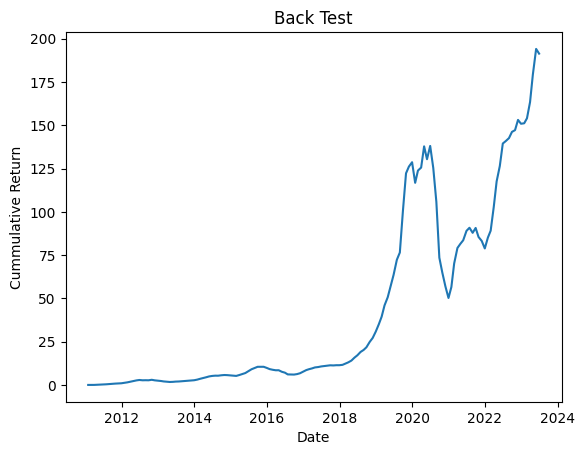

In [ ]:
# Plot the cummulative returns

sns.lineplot(data=spread,x='caldt',y='cum_ret')

plt.ylabel("Cummulative Return")

plt.xlabel("Date")

plt.title("Back Test")